# Dataset Information Creation
Create a json file to represent the files inside the dataset

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
import torch.nn as nn
import os
from birdlib import utils

In [2]:
# sudo modprobe nvidia_uvm
torch.cuda.is_available()

True

In [3]:
DATASET_NAME = "dataset"
MODEL_NAME = 'VanillaCNN'
DATASET_VAR = 'base_5'

In [4]:
DATASET_PATH = f'../segments/{DATASET_NAME}'
TRAIN_PATH = f"{DATASET_PATH}/train"
VALID_PATH = f"{DATASET_PATH}/valid"
TEST_PATH = f"{DATASET_PATH}/test"
MODEL_PATH = f'./models/{MODEL_NAME}'

# Create Dataset Config

In [5]:
def create_dataset_config(dataset_name, config_file_name='dataset_config.json'):
    saving_path = f"utils/{dataset_name}/{config_file_name}"
    if os.path.exists(saving_path):
        print("Dataset config already created!")
        with open(saving_path) as f:
            return json.load(f)

    mappings = utils.get_mappings(TRAIN_PATH)
    samples = utils.collect_samples(TRAIN_PATH, VALID_PATH, TEST_PATH, mappings)

    dataset_config = {
        "mappings": mappings,
        "samples": samples
    }
    with open(saving_path, "w") as f:
        json.dump(dataset_config, f)
    print("Saved new dataset config")
    return dataset_config

In [6]:
dataset_config = create_dataset_config(DATASET_NAME, f'dataset_config_{DATASET_VAR}.json')
mappings = dataset_config["mappings"]

Dataset config already created!


## Load the model

In [7]:
model_class = utils.load_model_class(MODEL_NAME)
model = model_class(len(mappings))

# Spectograms Creation

In [8]:
SPECS_TRAIN_PATH = f"{DATASET_PATH}/train_specs"
SPECS_VALID_PATH = f"{DATASET_PATH}/valid_specs"
SPECS_TEST_PATH = f"{DATASET_PATH}/test_specs"
os.makedirs(SPECS_TRAIN_PATH, exist_ok=True)
os.makedirs(SPECS_VALID_PATH, exist_ok=True)
os.makedirs(SPECS_TEST_PATH, exist_ok=True)
utils.specs_generation(TRAIN_PATH, SPECS_TRAIN_PATH, dataset_config['mappings'])
utils.specs_generation(VALID_PATH, SPECS_VALID_PATH, dataset_config['mappings'])
utils.specs_generation(TEST_PATH, SPECS_TEST_PATH, dataset_config['mappings'])

Processing: Aeroplane
Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Cuculus canorus_Common Cuckoo
Processing: Regulus regulus_Goldcrest
Processing: Anthus trivialis_Tree Pipit
Processing: Vegetation
Processing: Troglodytes troglodytes_Eurasian Wren
Processing: Erithacus rubecula_European Robin
Processing: None
Processing: Parus major_Great Tit
Processing: Certhia familiaris_Eurasian Treecreeper
Processing: Phylloscopus collybita_Common Chiffchaff
Processing: Coccothraustes coccothraustes_Hawfinch
Processing: Wind
Processing: Turdus merula_Eurasian Blackbird
Processing: Loxia curvirostra_Common Crossbill
Processing: Regulus ignicapilla_Common Firecrest
Processing: Sylvia atricapilla_Eurasian Blackcap
Processing: Lophophanes cristatus_Crested Tit
Processing: Fringilla coelebs_Common Chaffinch
Processing: Aeroplane
Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Cuculus canorus_Common Cucko

'✅ Spettrogrammi generati e salvati.'

# Model

In [9]:
# Esempio fittizio
label_counts = { species: len(os.listdir(os.path.join(TRAIN_PATH, species))) for species in os.listdir(TRAIN_PATH)}
counts = torch.tensor(list(label_counts.values()), dtype=torch.float32)
inv_freq = 1.0 / (counts + 1e-6)
pos_weight = inv_freq / inv_freq.mean()  # normalize around 1
names = list(label_counts.keys())
importance_map = {
    'Aeroplane': 0.1,
    'Wind': 0.1,
    'Vegetation': 0.1,
    'None': 0.0,
    # fallback = 1.0
}

importance = torch.tensor([importance_map.get(name, 1.0) for name in names])
final_pos_weight = pos_weight * importance + 1e-3

final_pos_weight, pos_weight, names
for i, name in enumerate(names):
    print(name, final_pos_weight[i])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_pos_weight = final_pos_weight.to(device)

Aeroplane tensor(0.2860)
Muscicapa striata_Spotted Flycatcher tensor(0.3238)
Periparus ater_Coal Tit tensor(0.1635)
Cuculus canorus_Common Cuckoo tensor(9.7237)
Regulus regulus_Goldcrest tensor(0.1754)
Anthus trivialis_Tree Pipit tensor(0.2484)
Vegetation tensor(0.0751)
Troglodytes troglodytes_Eurasian Wren tensor(0.1370)
Erithacus rubecula_European Robin tensor(0.0982)
None tensor(0.0010)
Parus major_Great Tit tensor(1.5314)
Certhia familiaris_Eurasian Treecreeper tensor(0.2774)
Phylloscopus collybita_Common Chiffchaff tensor(0.0765)
Coccothraustes coccothraustes_Hawfinch tensor(2.0167)
Wind tensor(0.0199)
Turdus merula_Eurasian Blackbird tensor(0.2185)
Loxia curvirostra_Common Crossbill tensor(0.9848)
Regulus ignicapilla_Common Firecrest tensor(0.0557)
Sylvia atricapilla_Eurasian Blackcap tensor(0.0432)
Lophophanes cristatus_Crested Tit tensor(1.1331)
Fringilla coelebs_Common Chaffinch tensor(0.0181)


In [10]:
@torch.no_grad()
def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    for mel_spec, labels, _ in val_loader:
        mel_spec = mel_spec.to(device)
        labels = labels.to(device)
        outputs = model(mel_spec)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
    return val_loss / len(val_loader)


In [11]:
def combined_loss(train_loss, val_loss, epoch, total_epochs):
    val_weight = min(0.9, epoch / (total_epochs * 0.6))  # Massimo 0.9
    train_weight = 1 - val_weight
    return train_weight * train_loss + val_weight * val_loss

In [12]:
def load_checkpoint(model, optimizer, scheduler, checkpoint_path):
    """Load model and optimizer state from the checkpoint"""
    if not os.path.exists(checkpoint_path):
        print("No weights found!")
        return None, 0, float("inf"), [], []
    
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    history_loss = checkpoint['history_loss']
    val_loss_history = checkpoint.get('val_loss_history', [])
    best_loss = checkpoint.get('combined_loss', float("inf"))
    
    return model, best_loss, history_loss, val_loss_history


In [13]:
def prepare_dataloaders(dataset_config, batch_size):
    """Prepare dataloaders for training and validation."""
    print("Loading training data...")
    train_loader = utils.get_dataloader(dataset_config, split="train", batch_size=batch_size)
    print("Loaded!")
    
    print("Loading validation data...")
    val_loader = utils.get_dataloader(dataset_config, split="valid", batch_size=batch_size)
    print("Loaded!")
    
    return train_loader, val_loader


In [14]:
def initialize_training_components(model, lr=1e-5, patience=3, pos_weight=None):
    """Initialize loss function, optimizer and scheduler."""
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=patience,
    )
    return criterion, optimizer, scheduler


In [15]:
def train_model(dataset_config, model, total_epochs=10, batch_size=100, lr=1e-5, patience=3, early_stop_patience=15, print_freq=100, load_weights=False, checkpoint_name='checkpoint.pth'):
    history_loss = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training {MODEL_NAME} on: {device}")

    model.to(device)
    criterion, optimizer, scheduler = initialize_training_components(model, lr, patience, final_pos_weight)

    history_loss = []
    val_loss_history = []

    best_loss = float("inf")

    saving_path = f'models/{MODEL_NAME}/{checkpoint_name}'
    if load_weights:
        model, best_loss, history_loss, val_loss_history = load_checkpoint(model, optimizer, scheduler, saving_path)
        if model is None:  # Checkpoint not found
            return None
    
    train_loader, val_loader = prepare_dataloaders(dataset_config, batch_size)
    
    early_stop_counter = 0
    for epoch in range(total_epochs):
        model.train()
        running_loss = 0.0
        print(f"\n🎯 Starting epoch {epoch + 1}/{total_epochs}")

        for batch_index, (mel_spec, labels, _) in enumerate(train_loader):
            mel_spec = mel_spec.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if batch_index % print_freq == 0:
                print('Epoch: [{0}][{1}/{2}], Loss: {loss:.5f}'.format(epoch, batch_index, len(train_loader), loss=loss))

        val_loss = evaluate(model, val_loader, criterion, device)
        val_loss_history.append(val_loss)
        train_loss = running_loss / len(train_loader)
        history_loss.append(train_loss)
        loss = combined_loss(train_loss, val_loss, epoch, total_epochs)
        scheduler.step(loss)


        np.save(f'models/{MODEL_NAME}/history_loss_{DATASET_VAR}.npy', history_loss)
        np.save(f'models/{MODEL_NAME}/val_loss_history_{DATASET_VAR}.npy', val_loss_history)
        if loss < best_loss:
            best_loss = loss
            early_stop_counter = 0
            print(f"💾 Saving improved model at epoch {epoch+1} with loss={loss:.5f}")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'combined_loss': loss,
                'history_loss': history_loss,
                'val_loss_history': val_loss_history
            }, saving_path)
        else:
            early_stop_counter += 1
            print(f"🛑 No improvement - early stop counter: {early_stop_counter}/{early_stop_patience}")

        print(f"🔁 Epoch {epoch + 1} completed - Combined loss: {loss:.7f} - LR: {optimizer.param_groups[0]['lr']:.1e}")

        if early_stop_counter >= early_stop_patience:
            print(f"\n🚨 Early stopping triggered after {early_stop_patience} epochs without improvement.")
            break

    print("✅ Training completed")

    return model


In [16]:
model = train_model(dataset_config, model, total_epochs=200, batch_size=16, print_freq=500, lr=1e-5, load_weights=False, checkpoint_name=f'checkpoint_{DATASET_VAR}.pth')

Training VanillaCNN on: cuda
Loading training data...
Loaded!
Loading validation data...
Loaded!

🎯 Starting epoch 1/200
Epoch: [0][0/2090], Loss: 0.65458
Epoch: [0][500/2090], Loss: 0.02038
Epoch: [0][1000/2090], Loss: 0.04895
Epoch: [0][1500/2090], Loss: 0.03260
Epoch: [0][2000/2090], Loss: 0.03128
💾 Saving improved model at epoch 1 with loss=0.03393
🔁 Epoch 1 completed - Combined loss: 0.0339311 - LR: 1.0e-05

🎯 Starting epoch 2/200
Epoch: [1][0/2090], Loss: 0.01018
Epoch: [1][500/2090], Loss: 0.01462
Epoch: [1][1000/2090], Loss: 0.03827
Epoch: [1][1500/2090], Loss: 0.01842
Epoch: [1][2000/2090], Loss: 0.01674
💾 Saving improved model at epoch 2 with loss=0.02349
🔁 Epoch 2 completed - Combined loss: 0.0234920 - LR: 1.0e-05

🎯 Starting epoch 3/200
Epoch: [2][0/2090], Loss: 0.02106
Epoch: [2][500/2090], Loss: 0.01558
Epoch: [2][1000/2090], Loss: 0.01274
Epoch: [2][1500/2090], Loss: 0.02205
Epoch: [2][2000/2090], Loss: 0.01506
💾 Saving improved model at epoch 3 with loss=0.02265
🔁 Epoch

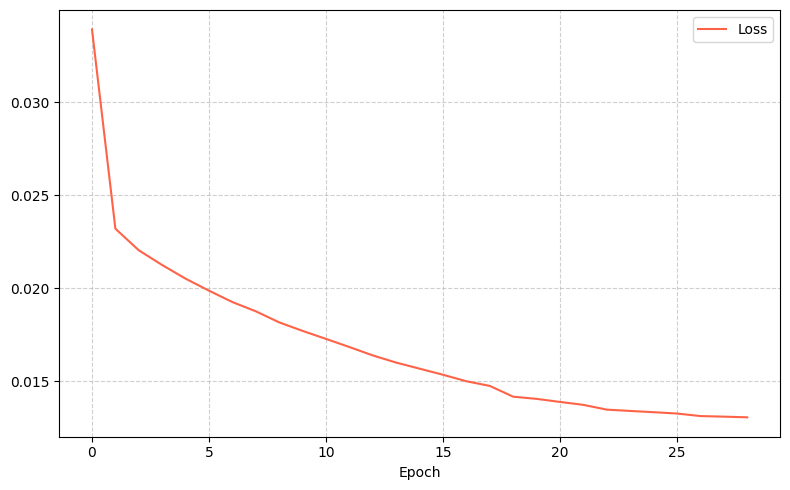

In [17]:
history_loss = np.load(f'models/{MODEL_NAME}/history_loss_{DATASET_VAR}.npy')
plt.figure(figsize=(8, 5))
plt.plot(history_loss, linestyle='-', color='tomato', label="Loss")
# plt.title(title)
plt.xlabel("Epoch")
# plt.ylabel(ylabel)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
torch.cuda.empty_cache()
os.getpid()

5084